In [1]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import scipy.optimize
import seaborn
from baseline_calculator import *
%matplotlib inline

In [2]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')
phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in(
    'Phoenix', businesses, reviews, users)
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

In [11]:
def summarize_performance(baseline_calculator, **kwargs):
    baseline_calculator.fit(reviews_train, **kwargs)
    print('for {}:'.format(baseline_calculator.__class__.__name__))
    train_rmse = baseline_calculator.baseline_rmse(reviews_train)
    test_rmse = baseline_calculator.baseline_rmse(reviews_test)
    print('train RMSE: {}'.format(train_rmse))
    print(' test RMSE: {}'.format(test_rmse))
    return train_rmse, test_rmse

### Really basic baselines -- averaging

In [51]:
ambc = AbsoluteMeanBaselineCalculator()
ambc_train_rmse, ambc_test_rmse = summarize_performance(ambc)

for AbsoluteMeanBaselineCalculator:
train RMSE: 1.35148870051
 test RMSE: 1.35392475252


In [52]:
sabc = SimpleAverageBaselineCalculator()
sabc_train_rmse, sabc_test_rmse = summarize_performance(sabc)

for SimpleAverageBaselineCalculator:
train RMSE: 0.976644727132
 test RMSE: 1.34699149129


### Beta prior method

In [9]:
bpbc = BetaPriorBaselineCalculator()
beta_priors = np.arange(2, 50, 1)
beta_train_rmses = []
beta_test_rmses = []
for prior_strength in beta_priors:
    bpbc.fit(reviews_train, prior_strength=prior_strength)
    beta_train_rmses.append(bpbc.baseline_rmse(reviews_train))
    beta_test_rmses.append(bpbc.baseline_rmse(reviews_test))

In [23]:
best_prior = beta_priors[np.argmin(beta_test_rmses)]
print('Best prior: {}'.format(best_prior))

beta_train_rmse, beta_test_rmse = summarize_performance(
    bpbc, prior_strength=best_prior)

Best prior: 8
for BetaPriorBaselineCalculator:
train RMSE: 1.09712142858
 test RMSE: 1.22970741401


### Decoupling + regularization (eqns 2 and 3 from BellKor 2009)

In [22]:
from collections import defaultdict

drbc = DecoupledRegularizedBaselineCalculator()
lambda1s = [0.1, 0.25, 0.5, 1, 2.25, 2.5, 2.75, 5, 10, 50]
lambda2s = [0.1, 0.25, 0.5, 1, 2.5, 4.75, 5, 5.25, 10, 50]
drbc_train_rmses = defaultdict(dict)
drbc_test_rmses = defaultdict(dict)

for lambda1 in lambda1s:
    for lambda2 in lambda2s:
        drbc.fit(reviews_train, busi_reg_strength=lambda1, user_reg_strength=lambda2)
        drbc_train_rmses[lambda1][lambda2] = drbc.baseline_rmse(reviews_train)
        drbc_test_rmses[lambda1][lambda2] = drbc.baseline_rmse(reviews_test)

In [35]:
drbc_test_rmse, drbc_train_rmse, l1, l2 = min([
        (test_rmses[l1][l2], train_rmses[l1][l2], l1, l2)
        for l1 in lambda1s for l2 in lambda2s])

print('Best lambdas: {} for businesses and {} for users'.format(l1, l2))
print('for DecoupledRegularizedBaselineCalculator:')
print('train RMSE: {}'.format(drbc_train_rmse))
print(' test RMSE: {}'.format(drbc_test_rmse))

Best lambdas: 2.75 for businesses and 5.25 for users
for DecoupledRegularizedBaselineCalculator:
train RMSE: 1.08195128135
 test RMSE: 1.22474806105


### Least-squares + L2 penalty (eqn 4 from BellKor 2009)

In [36]:
lsbc = L2RegLeastSquaresBaselineCalculator()

l2_penalties = [0.1, 0.4, 0.5, 0.6, 1, 5, 7.5, 10, 12.5, 100]
lsbc_train_rmses = []
lsbc_test_rmses = []
for l2 in l2_penalties:
    lsbc.fit(reviews_train, l2_penalty=l2, tol=5, verbose=False, maxiters=1000, learning_rate=0.00001)
    lsbc_train_rmses.append(lsbc.baseline_rmse(reviews_train))
    lsbc_test_rmses.append(lsbc.baseline_rmse(reviews_test))

In [37]:
i = np.argmin(lsbc_test_rmses)
l2 = l2_penalties[i]
lsbc_train_rmse = lsbc_train_rmses[i]
lsbc_test_rmse = lsbc_test_rmses[i]
print('best l2 penalty: {}'.format(l2))
print('for L2RegLeastSquaresBaselineCalculator:')
print('train RMSE: {}'.format(lsbc_train_rmse))
print(' test RMSE: {}'.format(lsbc_test_rmse))

best l2 penalty: 5
for L2RegLeastSquaresBaselineCalculator:
train RMSE: 1.08772407792
 test RMSE: 1.225275818


In [38]:
narrower_l2_penalties = [4, 4.5, 5, 5.5, 6]
narrower_lsbc_train_rmses = []
narrower_lsbc_test_rmses = []
for l2 in narrower_l2_penalties:
    lsbc.fit(reviews_train, l2_penalty=l2, tol=5, verbose=False, maxiters=1000, learning_rate=0.00001)
    narrower_lsbc_train_rmses.append(lsbc.baseline_rmse(reviews_train))
    narrower_lsbc_test_rmses.append(lsbc.baseline_rmse(reviews_test))

In [42]:
i = np.argmin(narrower_lsbc_test_rmses)
l2 = narrower_l2_penalties[i]
lsbc_train_rmse = narrower_lsbc_train_rmses[i]
lsbc_test_rmse = narrower_lsbc_test_rmses[i]
print('best l2 penalty: {}'.format(l2))
print('for L2RegLeastSquaresBaselineCalculator:')
print('train RMSE: {}'.format(lsbc_train_rmse))
print(' test RMSE: {}'.format(lsbc_test_rmse))

best l2 penalty: 4.5
for L2RegLeastSquaresBaselineCalculator:
train RMSE: 1.08200029808
 test RMSE: 1.22513266487


### Comparison

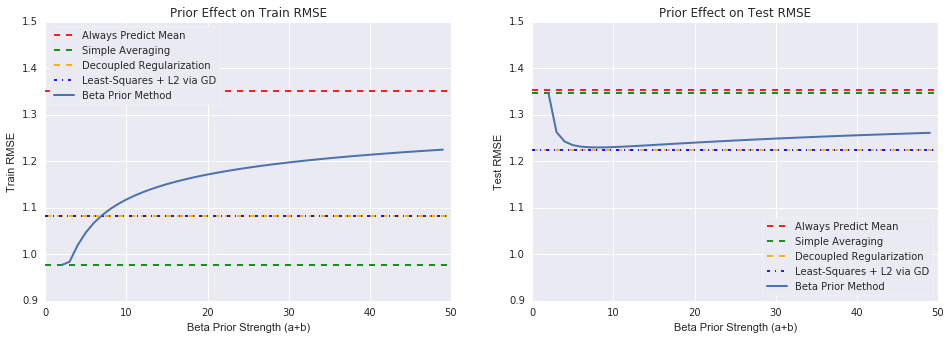

In [174]:
fig = plt.figure(figsize=(16,5))

fig.add_subplot(121)
plt.title('Prior Effect on Train RMSE')
plt.ylabel('Train RMSE')
plt.xlabel('Beta Prior Strength (a+b)')
plt.axhline(ambc_train_rmse, label=r'Always Predict Mean', ls='--', color='red')
plt.axhline(sabc_train_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(drbc_train_rmse, label='Decoupled Regularization', ls='--', color='orange')
plt.axhline(lsbc_train_rmse, label='Least-Squares + L2 via GD', ls='-.', color='blue')
plt.plot(beta_priors, beta_train_rmses, label='Beta Prior Method', lw=2)
plt.ylim(0.9, 1.5)
plt.legend(loc='upper left', frameon=True)

fig.add_subplot(122)
plt.title('Prior Effect on Test RMSE')
plt.ylabel('Test RMSE')
plt.xlabel('Beta Prior Strength (a+b)')
plt.axhline(ambc_test_rmse, label=r'Always Predict Mean', ls='--', color='red')
plt.axhline(sabc_test_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(drbc_test_rmse, label='Decoupled Regularization', ls='--', color='orange')
plt.axhline(lsbc_test_rmse, label='Least-Squares + L2 via GD', ls='-.', color='blue')
plt.plot(beta_priors, beta_test_rmses, label='Beta Prior Method', lw=2)
plt.ylim(0.9, 1.5)
plt.legend(loc='lower right', frameon=True)

plt.show()

We should expect that baselines which obtain similar RMSE also have similar values for $b_u$ and $b_i$ -- let's check that quickly:

In [55]:
def avg_distance_between_baselines(bc1, bc2):
    tot = 0
    for u in reviews_train.user_id.unique():
        tot += (bc1.user_baselines[u] - bc2.user_baselines[u])**2
    for b in reviews_train.business_id.unique():
        tot += (bc1.busi_baselines[b] - bc2.busi_baselines[b])**2
    return np.sqrt(tot) / float(len(reviews_train))

In [54]:
lsbc.fit(reviews_train, l2_penalty=4.5, tol=5, verbose=False, maxiters=1000, learning_rate=0.00001)
drbc.fit(reviews_train, busi_reg_strength=2.75, user_reg_strength=5.25)
bpbc.fit(reviews_train, prior_strength=8)

In [56]:
avg_distance_between_baselines(lsbc, drbc)

3.5663819372490444e-05

In [57]:
avg_distance_between_baselines(lsbc, bpbc)

7.903969892742913e-05

In [58]:
avg_distance_between_baselines(drbc, bpbc)

8.7646976020469883e-05

In [60]:
avg_distance_between_baselines(drbc, sabc)

0.00092177014064343606

The above shows that the Least-Squares and Decoupled Regularized baselines end up finding more similar parameters than the other methods, which makes sense.

Now let's try some custom-column based methods that mostly explore time and frequency (per user or business):

In [81]:
by_l2_penalties = np.arange(5, 15, 1)
bybc = BusinessYearBaselineCalculator()
bybc_train_rmses = []
bybc_test_rmses = []
for l2 in by_l2_penalties:
    bybc.fit(reviews_train, l2_penalty=l2, tol=5, verbose=False, maxiters=1000, learning_rate=0.00001)
    bybc_train_rmses.append(bybc.baseline_rmse(reviews_train))
    bybc_test_rmses.append(bybc.baseline_rmse(reviews_test))

1.22580010432


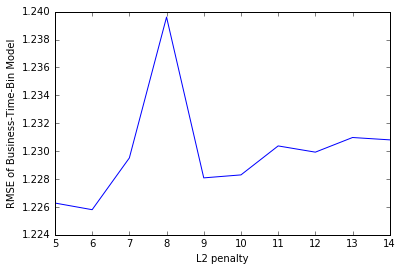

In [104]:
print min(bybc_test_rmses)
plt.plot(by_l2_penalties, bybc_test_rmses)
plt.xlabel('L2 penalty')
plt.ylabel('RMSE of Business-Time-Bin Model')
plt.show()

In [3]:
b6mbc = Business6MonthBaselineCalculator()
b6mbc.fit(reviews_train, l2_penalty=7, tol=5, maxiters=1000, learning_rate=0.00001)

loss at iter 0: 828243.5744044604
loss at iter 25: 776445.9436448399
loss at iter 50: 694874.0899386564
loss at iter 75: 625830.2007411734
loss at iter 100: 585264.038672758
loss at iter 125: 581762.0493888604


In [4]:
b6mbc.baseline_rmse(reviews_test)

1.22982688572793

In [5]:
fybc = FreqYearBaselineCalculator()
fybc.fit(reviews_train, l2_penalty=7, tol=5, maxiters=1000, learning_rate=0.00001)

loss at iter 0: 828243.5744044604
loss at iter 25: 822457.5569607995
loss at iter 50: 819238.5965239974


In [6]:
fybc.baseline_rmse(reviews_test)

1.3461154706856089

In [ ]:
penalties = [0.1, 1, 3, 5, 7, 10]
test_rmses = []
for p in penalties:
    mrbc = MoreThanOneReviewBizBaselineCalculator()
    mrbc.fit(reviews_train, l2_penalty=p, tol=5, maxiters=1000, learning_rate=0.00001, verbose=False)
    test_rmses.append(mrbc.baseline_rmse(reviews_test))

In [ ]:
print min(test_rmses)
penalties[np.argmin(test_rmses)]

In [10]:
mrbc = MoreThanOneReviewBizBaselineCalculator()
mrbc.fit(reviews_train, l2_penalty=5, tol=3, maxiters=1000, learning_rate=0.00001, verbose=False)
mrbc.baseline_rmse(reviews_test)

1.2247027310455518

In [12]:
mrbc = MoreThanOneReviewBizBaselineCalculator()
mrbc.fit(reviews_train, l2_penalty=4, tol=1, maxiters=1000, learning_rate=0.00001, verbose=False)
mrbc.baseline_rmse(reviews_test)

1.2255071075691415

In [13]:
mrbc = MoreThanOneReviewBizBaselineCalculator()
mrbc.fit(reviews_train, l2_penalty=6, tol=1, maxiters=1000, learning_rate=0.00001, verbose=False)
mrbc.baseline_rmse(reviews_test)

1.224904626132298

In [15]:
mrbc = MoreThanOneReviewBizBaselineCalculator()
mrbc.fit(reviews_train, l2_penalty=4.75, tol=1, maxiters=1000, learning_rate=0.00001, verbose=False)
mrbc.baseline_rmse(reviews_test)

1.2241024983167976

In [16]:
mrbc = MoreThanOneReviewBizBaselineCalculator()
mrbc.fit(reviews_train, l2_penalty=4.5, tol=1, maxiters=1000, learning_rate=0.00001, verbose=False)
mrbc.baseline_rmse(reviews_test)

1.2240404851845823

In [18]:
mrbc = MoreThanOneReviewBizBaselineCalculator()
mrbc.fit(reviews_train, l2_penalty=4.67, tol=1, maxiters=1000, learning_rate=0.00001, verbose=False)
mrbc.baseline_rmse(reviews_test)

1.2238666738910313

The above is actually our best result -- so perhaps frequencies help.

The Netflix paper mentions that frequency information works best when applied as a per-business parameter, but let's also try it as a per-user parameter (despite the fact that that will introduce many more new parameters, since there are ~1e6 users as opposed to 1e5 businesses):

In [9]:
mubc = MoreThanOneReviewUserBaselineCalculator()
mubc.fit(reviews_train, l2_penalty=10, tol=5, maxiters=1000, learning_rate=0.00001, verbose=False)
mubc.baseline_rmse(reviews_test)

1.2290238663168427

In [11]:
mubc = MoreThanOneReviewUserBaselineCalculator()
mubc.fit(reviews_train, l2_penalty=15, tol=5, maxiters=1000, learning_rate=0.00001, verbose=False)
mubc.baseline_rmse(reviews_test)

1.2322530814836508